In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.initializers import glorot_uniform


In [4]:

# Step 1: Preprocess Images
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: Image at path {image_path} could not be loaded.")
        return None
    img = cv2.resize(img, (450, 450), interpolation=cv2.INTER_LINEAR)
    img = img.astype(np.float32)
    img = img / 255.0  # Normalize pixel values to the range [0, 1]
    return img

# Step 2: Load Images and Labels
def load_images_and_labels(labels_df, images_dir):
    images = []
    sun_labels = []
    bbox_labels = []

    for index, row in labels_df.iterrows():
        img_path = os.path.join(images_dir, row['filename'])
        image = preprocess_image(img_path)
        if image is None:
            continue

        images.append(image)

        sun_label = row['sun']
        none_label = row['none']

        if sun_label == 1 and none_label == 0:
            bbox_label = [row['xmin'] / 450, row['ymin'] / 450, row['xmax'] / 450, row['ymax'] / 450]
        elif sun_label == 0 and none_label == 1:
            bbox_label = [0, 0, 0, 0]
        else:
            raise ValueError("Invalid label combination")

        sun_labels.append(sun_label)
        bbox_labels.append(bbox_label)

    return np.array(images), np.array(sun_labels), np.array(bbox_labels)

# Load new training and testing data
new_train_labels = pd.read_csv(r'E:\project\model\train.csv')
new_test_labels = pd.read_csv(r'E:\project\model\test.csv')

new_train_images, new_train_sun_labels, new_train_bbox_labels = load_images_and_labels(new_train_labels, r'E:\project\model\train')
new_test_images, new_test_sun_labels, new_test_bbox_labels = load_images_and_labels(new_test_labels, r'E:\project\model\test')

# Reshape images to add channel dimension for grayscale images
new_train_images = new_train_images[..., np.newaxis]
new_test_images = new_test_images[..., np.newaxis]

print("New train images shape:", new_train_images.shape)
print("New train sun labels shape:", new_train_sun_labels.shape)
print("New train bbox labels shape:", new_train_bbox_labels.shape)

print("New test images shape:", new_test_images.shape)
print("New test sun labels shape:", new_test_sun_labels.shape)
print("New test bbox labels shape:", new_test_bbox_labels.shape)


New train images shape: (10000, 450, 450, 1)
New train sun labels shape: (10000,)
New train bbox labels shape: (10000, 4)
New test images shape: (2500, 450, 450, 1)
New test sun labels shape: (2500,)
New test bbox labels shape: (2500, 4)


In [5]:
# Split the training data into new training and validation sets
new_train_images, new_val_images, new_train_sun_labels, new_val_sun_labels, new_train_bbox_labels, new_val_bbox_labels = train_test_split(
    new_train_images, new_train_sun_labels, new_train_bbox_labels, test_size=0.2, random_state=42)

In [6]:
def create_yolo_model(input_shape=(450, 450, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Convolutional layers
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten the feature map
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Dense layers for bounding box prediction
    bbox_output = tf.keras.layers.Dense(512, activation='relu')(x)
    bbox_output = tf.keras.layers.Dense(256, activation='relu')(bbox_output)
    bbox_output = tf.keras.layers.Dense(4, activation='sigmoid', name='bbox_output')(bbox_output)  # 4 output neurons for bounding box coordinates (xmin, ymin, xmax, ymax)

    # Dense layers for sun existence prediction
    sun_output = tf.keras.layers.Dense(512, activation='relu')(x)
    sun_output = tf.keras.layers.Dense(256, activation='relu')(sun_output)
    sun_output = tf.keras.layers.Dense(1, activation='sigmoid', name='sun_output')(sun_output)  # 1 output neuron for sun existence (0 or 1)

    model = tf.keras.Model(inputs=inputs, outputs=[sun_output, bbox_output])

    return model

# Create the YOLO-inspired model
model = create_yolo_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 450, 450,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 450, 450,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 225, 225,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 225, 225,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 56, 56,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 28, 28,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 14, 14,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100352)    │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100352)    │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │ 51,380,736 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │ 51,380,736 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    131,328 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sun_output (Dense)  │ (None, 1)         │        257 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │      1,028 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 104,593,413 (398.99 MB)

 Trainable params: 104,593,413 (398.99 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'sun_output': 'binary_crossentropy',
        'bbox_output': 'mean_squared_error'
    },
    metrics={
        'sun_output': ['accuracy'],
        'bbox_output': ['mse']
    }
)

# Fit the model
history = model.fit(
    new_train_images,
    {'sun_output': new_train_sun_labels, 'bbox_output': new_train_bbox_labels},
    validation_data=(
        new_val_images,
        {'sun_output': new_val_sun_labels, 'bbox_output': new_val_bbox_labels}
    ),
    epochs=10,  # You can adjust the number of epochs
    batch_size=32,  # You can adjust the batch size
    verbose=1
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1566s 6s/step - bbox_output_mse: 0.0452 - loss: 0.4091 - sun_output_accuracy: 0.8171 - val_bbox_output_mse: 0.0074 - val_loss: 0.0414 - val_sun_output_accuracy: 0.9885
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1528s 6s/step - bbox_output_mse: 0.0040 - loss: 0.0244 - sun_output_accuracy: 0.9934 - val_bbox_output_mse: 0.0020 - val_loss: 0.0070 - val_sun_output_accuracy: 0.9990
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1527s 6s/step - bbox_output_mse: 0.0019 - loss: 0.0075 - sun_output_accuracy: 0.9980 - val_bbox_output_mse: 0.0084 - val_loss: 0.0390 - val_sun_output_accuracy: 0.9915
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2015s 8s/step - bbox_output_mse: 0.0044 - loss: 0.0311 - sun_output_accuracy: 0.9912 - val_bbox_output_mse: 0.0011 - val_loss: 0.0034 - val_sun_output_accuracy: 0.9995
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1720s 7s/step - bbox_output_mse: 0.0026 - loss: 0.0257 - sun_output_accuracy: 0.9934 - val_bbox_output_mse: 0.0019 - val_loss: 0

In [9]:
# Evaluate the model and print the results
evaluation_results = model.evaluate(
    new_test_images,
    {'sun_output': new_test_sun_labels, 'bbox_output': new_test_bbox_labels},
    verbose=1
)

print("Evaluation results:", evaluation_results)


79/79 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - bbox_output_mse: 0.0652 - loss: 3.0546 - sun_output_accuracy: 0.7879
Evaluation results: [1.1570754051208496, 0.027942046523094177, 0.9120000004768372]


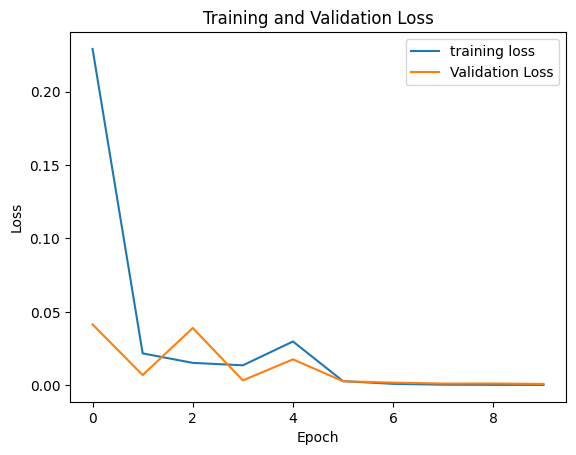

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [10]:
from tensorflow.keras.models import load_model

model.save('E:\project\model\sun_detect.h5')

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14532\3350550438.py:3: SyntaxWarning: invalid escape sequence '\p'
  model.save('E:\project\model\sun_detect.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


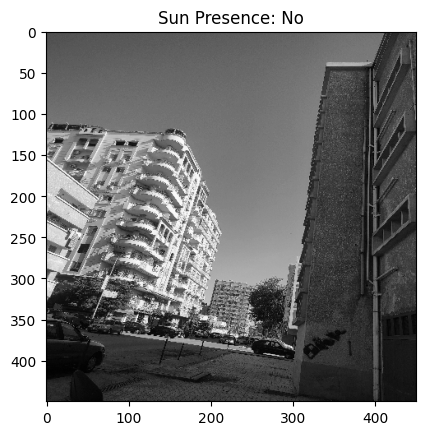

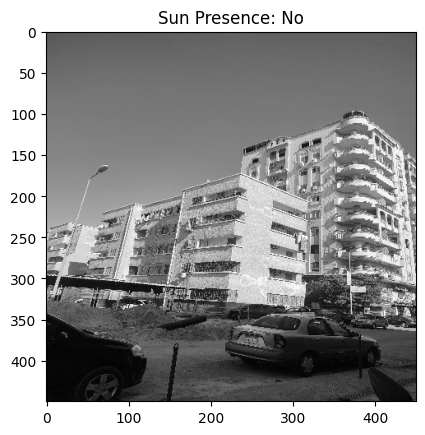

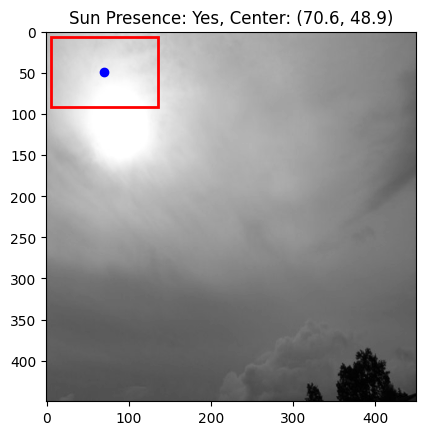

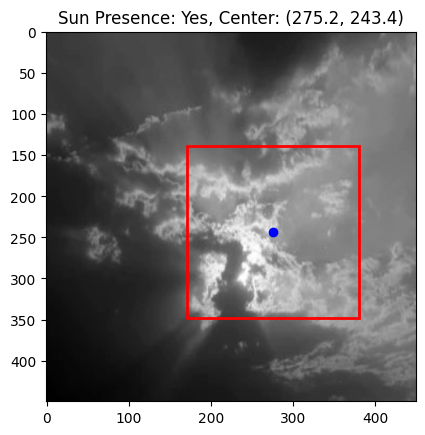

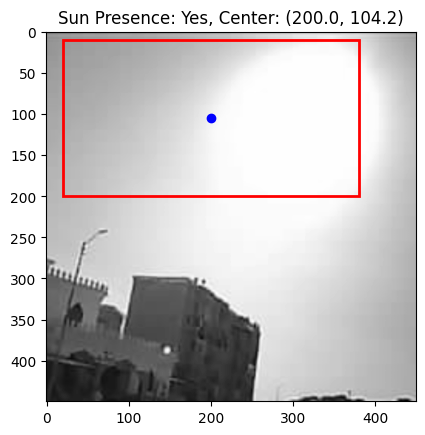

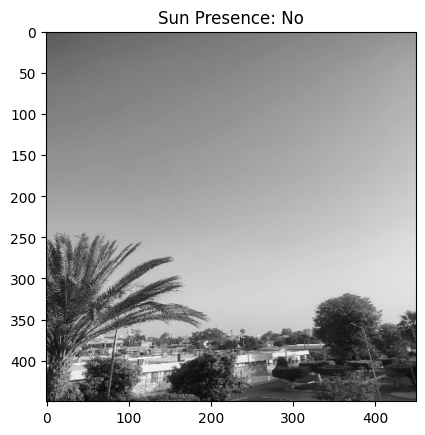

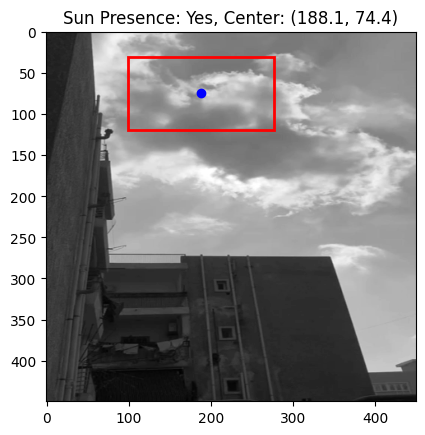

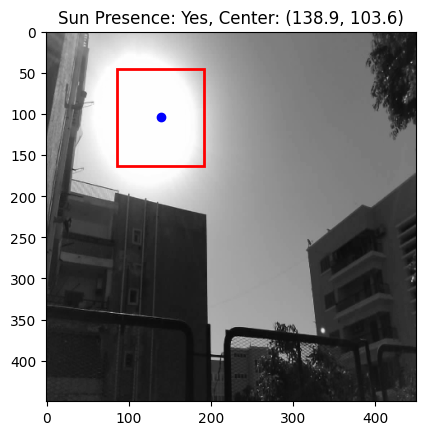

In [13]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

# Helper functions
def preprocess_image_for_visualization(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: Image at path {image_path} could not be loaded.")
        return None
    img = cv2.resize(img, (450, 450), interpolation=cv2.INTER_LINEAR)
    img = img.astype(np.float32)
    img = img / 255.0  # Normalize pixel values to the range [0, 1]
    img = img[..., np.newaxis]  # Add channel dimension for grayscale images
    return img

def load_images_from_folder(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.JPG')):
            img_path = os.path.join(folder_path, filename)
            img = preprocess_image_for_visualization(img_path)
            if img is not None:
                images.append(img)
                filenames.append(filename)
    return np.array(images), filenames

def plot_predictions(images, filenames, sun_predictions, bbox_predictions):
    for i in range(len(images)):
        img = images[i]
        sun_pred = sun_predictions[i]
        bbox_pred = bbox_predictions[i]

        # Rescale bbox predictions to original image size
        xmin, ymin, xmax, ymax = bbox_pred * 450
        center_x = (xmin + xmax) / 2
        center_y = (ymin + ymax) / 2

        fig, ax = plt.subplots(1)
        ax.imshow(img.squeeze(), cmap='gray')

        # Add bounding box and center point
        if sun_pred > 0.5:  # If the model predicts sun presence
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.plot(center_x, center_y, 'bo')  # Mark the center point with a blue dot
            plt.title(f"Sun Presence: Yes, Center: ({center_x:.1f}, {center_y:.1f})")
        else:
            plt.title(f"Sun Presence: No")

        plt.show()

# Path to the folder containing the images
folder_path = r'E:\project\model\demo'

# Load images from the folder
images, filenames = load_images_from_folder(folder_path)

# Make predictions using the trained model
sun_predictions, bbox_predictions = model.predict(images)

# Plot predictions
plot_predictions(images, filenames, sun_predictions, bbox_predictions)
